In [1]:
from PIL import Image
import requests
import io
import math
from scipy import misc
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

import panopticapi
from panopticapi.utils import id2rgb, rgb2id

# import key libraries
from PIL import Image, ImageDraw
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy import misc
import scipy.ndimage


In [2]:
def collect_mp4_frames(link):
    # create video capture instance
    vidcap = cv2.VideoCapture(link)
    success,image = vidcap.read()
    frames = [image]
    # iterate over video frames, save each in a list
    while success:
        success,image = vidcap.read()
        frames.append(image)
    return frames

def create_predictor():
    # create Detectron2 config and Default Predictor to run image inference
    cfg = get_cfg()
    # add project-specific config here if not running a model in Detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
    cfg.MODEL.DEVICE = 'cpu'
    # find a model from detectron2's model zoo.
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    # build predictor
    predictor = DefaultPredictor(cfg)
    return predictor

def blur_people(img, predictor):
    # image in tensor form
    im = np.array(img)
    # image dimensions
    height, width, channels = im.shape
    # run inference on the image
    outputs = predictor(im)
    # get indices of predicted instances that are labelled as people
    person_idx = (outputs["instances"].pred_classes==0)
    # count of 'people' instances
    person_count = np.sum(np.array(person_idx))
    # get image masks corresponding to each identified person
    person_masks_tensor = outputs["instances"].pred_masks[person_idx,:,:]
    # create PIL image masks
    person_masks = Image.new('L', im.shape[:-1], 0)
    draw = ImageDraw.Draw(person_masks)    
    # create mask and add peoples' shape to it
    sharp_mask = np.zeros((height, width, channels))
    for i in range(person_count):
        sharp_mask[person_masks_tensor[i,:,:]==1]=1
    # filtered image
    result = (np.multiply(filter_image(img),sharp_mask)+img).astype(dtype=np.uint8)            
    return result

def filter_image(sharp_image):
    # does what it says on the tin
    blurred_image = scipy.ndimage.filters.sobel(sharp_image, mode='constant')
    blurred_image = scipy.ndimage.filters.prewitt(blurred_image, mode='reflect')
    return blurred_image

In [3]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
    if c != "N/A":
        coco2d2[i] = count
        count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();

Using cache found in /home/adrien/.cache/torch/hub/facebookresearch_detr_master


In [13]:
VIDEO_PATH = 'video/IMG_0240.mp4'
frames = collect_mp4_frames(VIDEO_PATH)

img = Image.fromarray(frames[0])

In [15]:
tensored_image = transform(img).unsqueeze(0)

out = model(b)

In [17]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(tensored_image.shape[-2:]).unsqueeze(0))[0]

/home/adrien/anaconda3/envs/mlp/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [18]:
result

{'png_string': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03 \x08\x02\x00\x00\x00T\x12\x91?\x00\x00\x9a:IDATx\x9c\xed\xfd\xe9\xb2\xdd\xb6\xce\xb6\x8d\xcaqF\x92\x95\xa6\xf6\xf9\x1f\xe6W+YiF\x9c\xec\x1fz\xacWS\x14)\x10\x1d\x01\xf2\xbe\xca\xe5\x1a\x9e\x1eS\xa2\xd8\x80\xb7@\x10\xfc\xf4\xc3\x06@&\xde\xa3\x0b\x00\x00\x00 \x1a/\xdf\xdbQf\xa2o\xccK\x01\x00\x00\x00\x00\xb0\x18\xdf\x8e.\x00\x00\x00\x00\x00@\x1f\xce.+\x06\x10X\x00\x00\x00\x00\x08M49\xf5"\xac\x12~B\x0c\x16H\x07\xc2\xb0\x00\x00`n\xa2)\xaa[\xda\x93\x11<X\x00\x00\x00\x00\x08A\n]E\x04A\xee\x00\x00\x00\x00\x18\xcc+\xa1\xbaj\x17\x18\x1e,\x90\x0c\xac\x0f\x02\x00\xc04\xa4\x13U\x17\x1a\xc1X\x10X \x13PW\x00\x00\x90\x9d\xec\xa2\x8a\x08\x04\x16\xc8\x01\xa4\x15\x00\x00\xa4fV]UsbA`\x81\x04@]\x01\x00@^f\x95V;X"\x04\x99\x80\xa2\x02\x00\x00\x10\x9f\xc6l\x85]\x84 \x1cPW\x00\x000\r\x13\xbb\xaf\x90\x07\x0b\xa4\x01\xd2\n\x00\x00\xc0\x1c@`\x81\xc1@T\x01\x00\xc0\xc4\xbc\'ub=N^X"\x04#\x81\xba\x02\x00\x80\xe9Y\xd3\xd4C`\x81a\x10\x87\\\xc6

In [19]:
# collect all 'person' mask IDs 
person_idx = [elt['id'] for elt in list(filter(lambda x: x['category_id']==1, result['segments_info']))]

In [20]:
# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_h, final_w = panoptic_seg.size
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# fix a black background and colour all people white
panoptic_seg[:,:,:] = 0
for id in person_idx:
    panoptic_seg[panoptic_seg_id==id] = 255

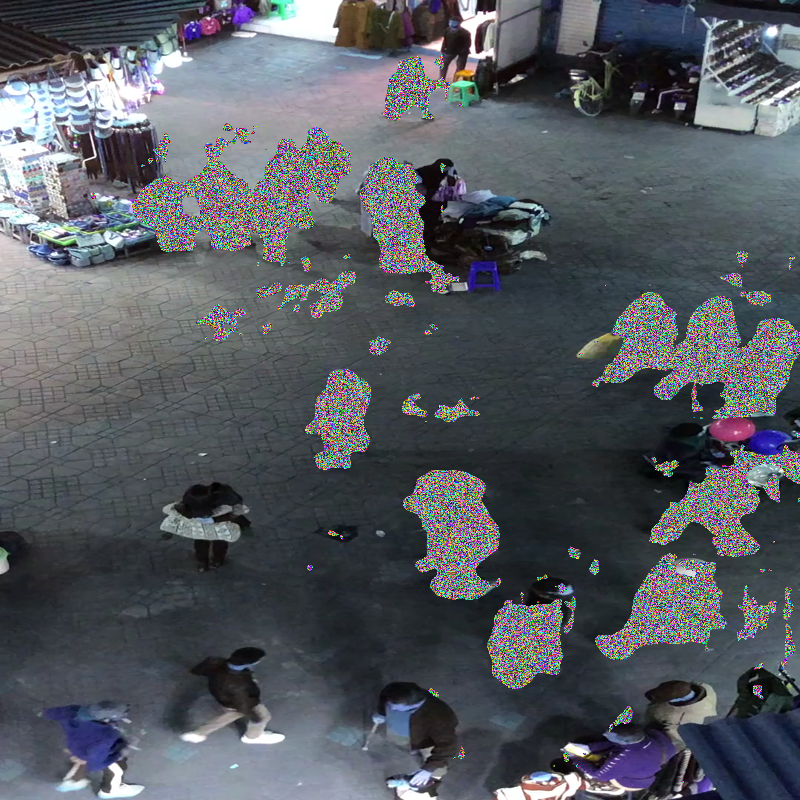

In [22]:
def filter_image(sharp_image):
    
    # does what it says on the tin
    blurred_image = scipy.ndimage.filters.sobel(sharp_image, mode='constant')
    blurred_image = scipy.ndimage.filters.prewitt(blurred_image, mode='reflect')
    
    return blurred_image

# resize the initial image to make it match the transformed one's format
init_img = numpy.array(img.copy().resize((final_w, final_h)))



# show the filtered image
Image.fromarray((np.multiply(filter_image(init_img), panoptic_seg)+init_img).astype(dtype=np.uint8))


In [ ]:
init_img.shape

In [ ]:
im = Image.open("sample_pics/idris.jpg")

img = transform(im).unsqueeze(0)
out = model(img)

# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

In [ ]:
result